In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx

import src
from src.reload import deep_reload

In [6]:
a = np.array([[1, 2, 3]])
b = a.copy()

a.T @ b, a.T + b

(array([[1, 2, 3],
        [2, 4, 6],
        [3, 6, 9]]),
 array([[2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]]))

In [120]:
f = lambda x: x.update({'f': 1})

a = {'f': 4}
f(a)
a

{'f': 1}

In [178]:
# Generating random graph
deep_reload(src)

# Seed for replication
seed = np.random.randint(0, sys.maxsize)
seed = 758712061200539789
# print(seed)

# Numbers of nodes origins, destinations, and chargers
n_nodes = 100
n_origins = 1
n_destinations = 5
n_chargers = 15

# Graph parameters
scale = (1e6, 1e6) # graph scale [m]
link_bounds = (1e-6, np.inf) # Link distance boundaries [m]
reference_distance = 200e3 # Characteristic distance for link probability function [m]
link_speeds = [105 / 3.6] # Possible values for link speeds [m/s]

# Number of cases for stochastic routing
n_cases = 30

# Vehicle parameters
ess_capacity = 80 * 3.6e6 # [J]
vehicle_efficiency = 500 # [J/m]
initial_soc = 1
max_soc = 1
min_soc = .2
charge_rate = 80e3 # [kW]

# Driver parameters
risk_tolerance = .1

# Charger parameters
usability_rate = 1
max_delay = 1 # [h]
availability_rate = 1
charge_price = .3 # [$/kWh]

rng = np.random.default_rng(seed)

# Graph generation
graph = src.rng.random_graph(
    n_nodes,
    scale = scale,
    reference_distance = reference_distance,
    link_bounds = link_bounds,
    link_speeds = link_speeds,
    seed = seed,
    range_multiplier = 1
)

# Origins and Destinations
origin_nodes, destination_nodes = src.rng.random_origin_destination(
    graph, n_origins, n_destinations, seed = seed)

# Adding cost objects to graph

# Chargers to add to charger nodes
def fun(x):

    x['soc'] = np.ones(n_cases) * initial_soc

    return x
    
functions = {
    'time': lambda x: x.update(
        {'time': x['time'] + ess_capacity * (1 - x['soc']) / charge_rate / 3600}),
    'price': lambda x: x.update(
        {'price': x['price'] + ess_capacity * (1 - x['soc']) * charge_price / 3.6e6 }),
    'soc': lambda x: x.update({'soc': 1})
}

# Adding to graph
graph, assigned_nodes = src.rng.random_attribute_assignment(
    graph, 'functions', [functions] * n_chargers, rng
)

# Defining the problem objective
deep_reload(src)

objectives = {
    'time': lambda x: src.utilities.super_quantile(x['time'], risk_tolerance),
}

constraints = {
    'soc_lower': (
        lambda x: src.utilities.super_quantile(x['soc'], risk_tolerance) >= min_soc
    ),
    'soc_upper': (
        lambda x: src.utilities.super_quantile(x['soc'], risk_tolerance) <= max_soc
    ),
}

states = {
    'soc': {
        'field': 'soc',
        'initial': np.array([initial_soc] * n_cases),
        'update': lambda x, v: src.routing.add_simple(
            x['soc'], -v['distance'] * vehicle_efficiency /  ess_capacity) ,
    },
    'time': {
        'field': 'time',
        'initial': np.array([0.] * n_cases),
        'update': lambda x, v: src.routing.add_simple(
            x['time'], v['time'] / 3600),
    },
    'time_nc': {
        'field': 'time',
        'initial': np.array([0.] * n_cases),
        'update': lambda x, v: src.routing.add_simple(
            x['time'], v['time'] / 3600),
    },
    'distance': {
        'field': 'distance',
        'initial': np.array([0.] * n_cases),
        'update': lambda x, v: src.routing.add_simple(
            x['distance'], v['distance'] / 1e3),
    },
    'price': {
        'field': 'price',
        'initial': np.array([0.] * n_cases),
        'update': lambda x, v: src.routing.add_simple(x['price'], v['price']),
    },
}

In [179]:
deep_reload(src)

t0 = time.time()
path_expectations, path_values, _ = src.routing.dijkstra(
    graph, 
    origin_nodes,
    destinations = [],
    states = states,
    constraints = constraints,
    objectives = objectives,
)
time.time() - t0

0.5770900249481201

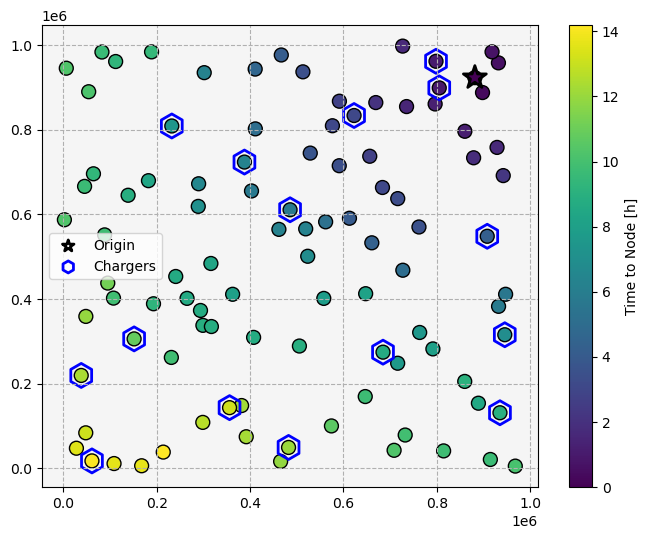

In [180]:
deep_reload(src)

path_values_avg = {}

for target, values in path_values.items():

    path_values_avg[target] = {}

    for key, val in values.items():

        path_values_avg[target][key] = src.utilities.super_quantile(val, 0, .01)

fig, ax  = plt.subplots(figsize = (8,6))

src.figures.dijkstra_output(
    graph, path_values_avg, origin_nodes, [], assigned_nodes, ax = ax,
    show_links = False, field = 'time')

_ = ax.set(**{'facecolor': 'whitesmoke'})
_ = ax.grid(ls = '--')

# fig.savefig('Document/figs/effect_of_charging_bev_c.png', bbox_inches = 'tight', dpi = 300)

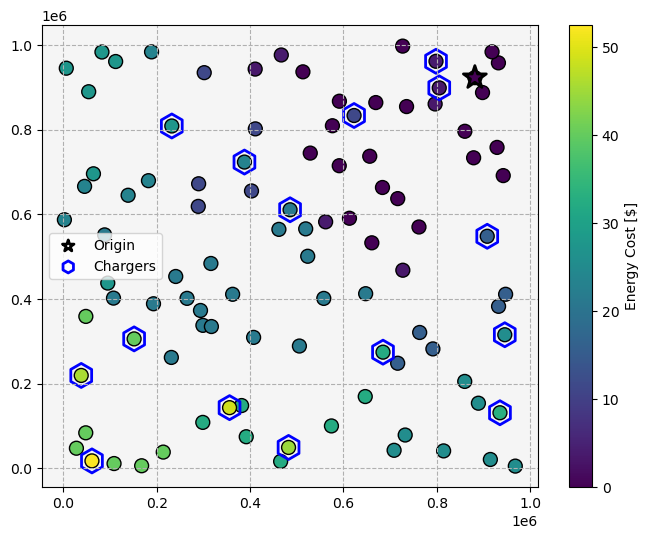

In [181]:
deep_reload(src)

path_values_avg = {}

for target, values in path_values.items():

    path_values_avg[target] = {}

    for key, val in values.items():

        path_values_avg[target][key] = src.utilities.super_quantile(val, 0, .01)

fig, ax  = plt.subplots(figsize = (8,6))

src.figures.dijkstra_output(
    graph, path_values_avg, origin_nodes, [], assigned_nodes, ax = ax,
    show_links = False, field = 'price', field_name = 'Energy Cost [$]')

_ = ax.set(**{'facecolor': 'whitesmoke'})
_ = ax.grid(ls = '--')

# fig.savefig('Document/figs/effect_of_charging_bev_c.png', bbox_inches = 'tight', dpi = 300)

In [122]:
# Generating random graph
deep_reload(src)

# Seed for replication
seed = np.random.randint(0, sys.maxsize)
seed = 758712061200539789
# print(seed)

# Numbers of nodes origins, destinations, and chargers
n_nodes = 100
n_origins = 1
n_destinations = 5
n_chargers = 100

# Graph parameters
scale = (1000, 1000) # graph scale [km]
link_bounds = (1e-6, np.inf) # Link distance boundaries [km]
reference_distance = 200 # Characteristic distance for link probability function [km]
link_speeds = [105] # Possible values for link speeds [km/h]

# Number of cases for stochastic routing
n_cases = 30

# Vehicle parameters
vehicle_range = 600.
min_range = 0

# Driver parameters
risk_tolerance = .01

# Charger parameters
charge_rate = 3600. # [km/h]
usability_rate = 1
max_delay = 1 # [h]
availability_rate = 1
charge_price = .09 # [$/km]

rng = np.random.default_rng(seed)

# Graph generation
graph = src.rng.random_graph(
    n_nodes,
    scale = scale,
    reference_distance = reference_distance,
    link_bounds = link_bounds,
    link_speeds = link_speeds,
    seed = seed,
    range_multiplier = 1
)

# Origins and Destinations
origin_nodes, destination_nodes = src.rng.random_origin_destination(
    graph, n_origins, n_destinations, seed = seed)

# Adding cost objects to graph

# Chargers to add to charger nodes

charger_kwargs = {
    'n_cases': n_cases,
    'reset_function': lambda x: (x < usability_rate) * vehicle_range,
    'rate_function': lambda x: np.array([charge_rate] * len(x)),
    'delay_function': lambda x: (
        (x > availability_rate) *
        (x - availability_rate) / (1 - availability_rate + 1e-6) *
        max_delay
    ),
    'price_function': lambda x: charge_price * (.9 + .2 * x),
    'rng': rng,
}

# Adding to graph
graph, charger_nodes = src.rng.random_chargers(graph, n_chargers, charger_kwargs, rng)

# Defining the problem objective
deep_reload(src)

objectives = {
    'time': lambda x: src.utilities.super_quantile(x['time'], risk_tolerance),
}

constraints = {
    'range': (
        lambda x: src.utilities.super_quantile(x['range'], risk_tolerance) > min_range
    ),
}

states = {
    'range': {
        'field': 'range',
        'initial': np.array([vehicle_range] * n_cases),
        'update': lambda x, v: x - v,
    },
    'time': {
        'field': 'time',
        'initial': np.array([0.] * n_cases),
        'update': lambda x, v: x + v,
    },
    'time_nc': {
        'field': 'time',
        'initial': np.array([0.] * n_cases),
        'update': lambda x, v: x + v,
    },
    'distance': {
        'field': 'distance',
        'initial': np.array([0.] * n_cases),
        'update': lambda x, v: x + v,
    },
    'price': {
        'field': 'price',
        'initial': np.array([0.] * n_cases),
        'update': lambda x, v: x + v,
    },
}

In [87]:
deep_reload(src)

t0 = time.time()
path_expectations, path_values, _ = src.routing.dijkstra(
    graph, 
    origin_nodes,
    destinations = [],
    states = states,
    constraints = constraints,
    objectives = objectives,
)
time.time() - t0

0.4490325450897217

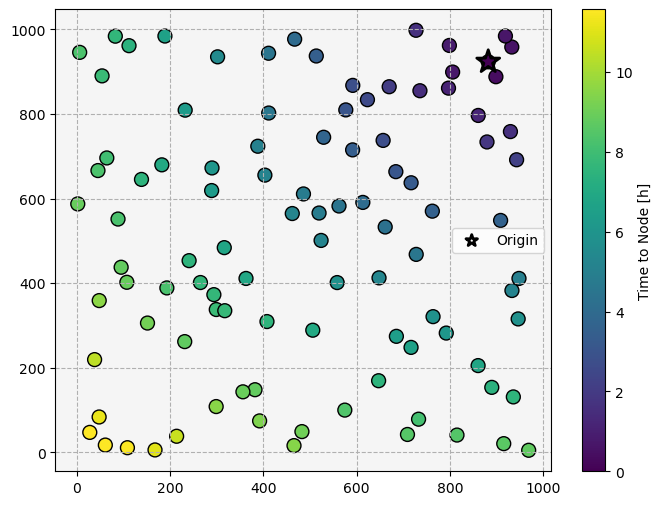

In [6]:
deep_reload(src)

path_values_avg_icev = {}

for target, values in path_values.items():

    path_values_avg_icev[target] = {}

    for key, val in values.items():

        path_values_avg_icev[target][key] = src.utilities.super_quantile(val, 0, .01)

fig, ax  = plt.subplots(figsize = (8,6))

src.figures.dijkstra_output(
    graph, path_values_avg_icev, origin_nodes, [], {}, ax = ax,
    show_links = False, field = 'time_nc')

_ = ax.set(**{'facecolor': 'whitesmoke'})
_ = ax.grid(ls = '--')

# fig.savefig('Document/figs/effect_of_charging_icev_nc.png', bbox_inches = 'tight', dpi = 300)

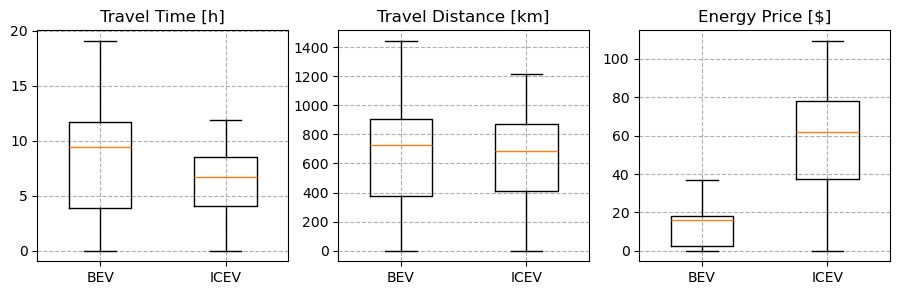

In [211]:
fig, ax = plt.subplots(1, 3, figsize = (11, 3))

kw = {
    'widths': .5,
    'labels': ['BEV', 'ICEV'],
}

data = [
    [v['time'] for v in path_values_avg.values()],
    [v['time'] for v in path_values_avg_icev.values()]
]

_ = ax[0].boxplot(data, **kw)
_ = ax[0].set(**{'title': 'Travel Time [h]'})

# data = [
#     [v['time_nc'] for v in path_values_avg.values()],
#     [v['time_nc'] for v in path_values_avg_icev.values()]
# ]

# _ = ax[1].boxplot(data)

data = [
    [v['distance'] for v in path_values_avg.values()],
    [v['distance'] for v in path_values_avg_icev.values()]
]

_ = ax[1].boxplot(data, **kw)
_ = ax[1].set(**{'title': 'Travel Distance [km]'})

data = [
    [v['price'] for v in path_values_avg.values()],
    [v['price'] for v in path_values_avg_icev.values()]
]

_ = ax[2].boxplot(data, **kw)
_ = ax[2].set(**{'title': 'Energy Price [$]'})

_ = [ax.grid(ls = '--') for ax in ax]

fig.savefig('Document/figs/routes_boxplots.png', bbox_inches = 'tight', dpi = 300)

In [12]:
76+76+116+116+121, 76 + 1 + -29 + -4 + 11

(505, 55)

In [77]:
ic = nx.information_centrality(graph)

In [79]:
bc = nx.betweenness_centrality(graph, weight = 'time')

In [127]:
vehicle_range = 350

for source, adj in graph._adj.items():
    for target, link in adj.items():
        
        link_range = link['distance']

    if link_range <= vehicle_range:

        # link['incidence'] = 1e20

    # else:

        link['incidence'] = link_range

ic = nx.information_centrality(graph, weight = 'incidence')
bc = nx.betweenness_centrality(graph, weight = 'incidence')

for source, node in graph._node.items():
    node['ic'] = ic[source]
    node['bc'] = bc[source]

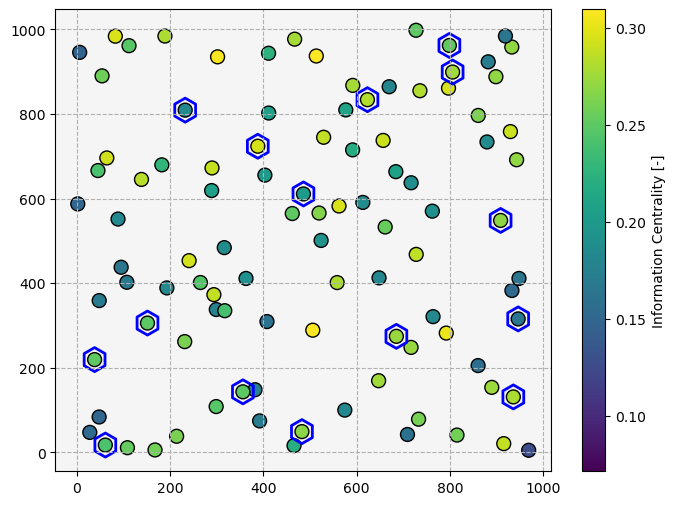

In [128]:
deep_reload(src)

fig, ax  = plt.subplots(figsize = (8,6))

kwargs = {
    'show_links': False,
    'node_field': 'ic',
    'scatter': {
        's': 100,
        'ec': 'k',
    },
    'plot': {
        'lw': .8,
        'zorder': 0,
        'color': 'lightgray',
    },
    'colorbar': {
        'label': 'Information Centrality [-]',
    }
}

src.figures.plot_graph(graph, ax = ax, **kwargs)

kwargs = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'b',
        'fc': 'none',
        'marker': 'h',
        'lw': 2,
        'label': 'Chargers',
    },
}

src.figures.plot_graph(src.graph.subgraph(graph, charger_nodes), ax = ax, **kwargs)
        
_ = ax.set(**{'facecolor': 'whitesmoke'})
_ = ax.grid(ls = '--')

fig.savefig('Document/figs/information_centrality.png', bbox_inches = 'tight', dpi = 300)

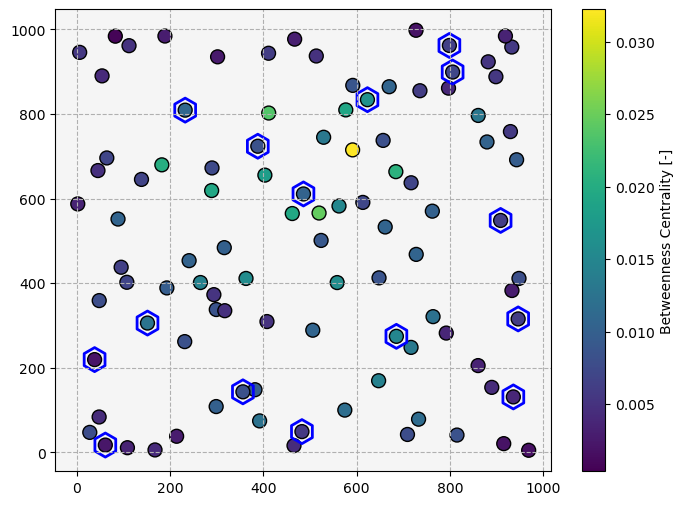

In [129]:
deep_reload(src)

fig, ax  = plt.subplots(figsize = (8,6))

kwargs = {
    'show_links': False,
    'node_field': 'bc',
    'scatter': {
        's': 100,
        'ec': 'k',
    },
    'plot': {
        'lw': .8,
        'zorder': 0,
        'color': 'lightgray',
    },
    'colorbar': {
        'label': 'Betweenness Centrality [-]',
    }
}

src.figures.plot_graph(graph, ax = ax, **kwargs)

kwargs = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'b',
        'fc': 'none',
        'marker': 'h',
        'lw': 2,
        'label': 'Chargers',
    },
}

src.figures.plot_graph(src.graph.subgraph(graph, charger_nodes), ax = ax, **kwargs)

_ = ax.set(**{'facecolor': 'whitesmoke'})
_ = ax.grid(ls = '--')

fig.savefig('Document/figs/betweenness_centrality.png', bbox_inches = 'tight', dpi = 300)

In [45]:
b = 1 - nx. to_numpy_array(graph)
for idx in range(b.shape[0]):

    b[idx, idx] = len(graph._adj[idx]) + 1

c = np.linalg.inv(b)

n = graph.number_of_nodes()

ic = 1 / (np.diag(c) + (np.diag(c).sum() - 2 * c.sum(axis = 0)) / n)
ic / n

array([0.11757634, 0.10654151, 0.08281115, 0.10866202, 0.11066125,
       0.10661698, 0.07220276, 0.08927329, 0.10863622, 0.12442201,
       0.08968786, 0.08605468, 0.05967254, 0.08955351, 0.11750986,
       0.10371569, 0.11395723, 0.12198703, 0.0684068 , 0.10657868,
       0.10891736, 0.10009697, 0.07673005, 0.11427045, 0.11059186,
       0.11355064, 0.11037081, 0.12321835, 0.09193098, 0.09202358,
       0.09464738, 0.09235853, 0.12336941, 0.12941236, 0.097581  ,
       0.10643617, 0.09424846, 0.10429271, 0.11196771, 0.09716985,
       0.08909476, 0.10642529, 0.09991661, 0.08313953, 0.10802308,
       0.12183237, 0.08616398, 0.09731472, 0.11912675, 0.11364571,
       0.07988523, 0.10779069, 0.11402352, 0.10661997, 0.09221805,
       0.08978304, 0.10208618, 0.10247486, 0.10133453, 0.07986148,
       0.09720423, 0.11559042, 0.0976887 , 0.09722298, 0.12198149,
       0.1058873 , 0.11728346, 0.11433483, 0.11031071, 0.05986444,
       0.08341596, 0.08937194, 0.10486665, 0.07619299, 0.10772

In [21]:
b = np.array([
    [4, 0, 1, 0, 0],
    [0, 4, 0, 1, 0],
    [1, 0, 3, 0, 1],
    [0, 1, 0, 3, 1],
    [0, 0, 1, 1, 3],
])

c = np.linalg.inv(b)

1 / (np.diag(c) + (np.diag(c).sum() - 2 * c.sum(axis = 0)) / c.shape[0])

array([1.77419355, 1.77419355, 1.41025641, 1.41025641, 1.375     ])

In [33]:
b = 1 - nx. to_numpy_array(graph)
for idx in range(b.shape[0]):

    b[idx, idx] = len(graph._adj[idx])

b.sum(axis = 0)

array([99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99.,
       99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99.,
       99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99.,
       99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99.,
       99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99.,
       99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99.,
       99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99., 99.,
       99., 99., 99., 99., 99., 99., 99., 99., 99.])

In [53]:
g = nx.Graph()
g.add_weighted_edges_from(
    [('A', 'B', 2),
     ('A', 'E', 5),
     ('B', 'E', 5),
     ('A', 'D', 1),
     ('B', 'C', 1),
     ('C', 'D', 10)]
)

In [54]:
nx.degree_centrality(g)

{'A': 0.75, 'B': 0.75, 'E': 0.5, 'D': 0.5, 'C': 0.5}

In [76]:
nx.betweenness_centrality(g, weight = 'weight')

{'A': 0.5, 'B': 0.5, 'E': 0.0, 'D': 0.0, 'C': 0.0}

In [71]:
nx.closeness_centrality(g, distance = 'weight')

{'A': 0.36363636363636365,
 'B': 0.36363636363636365,
 'E': 0.18181818181818182,
 'D': 0.2857142857142857,
 'C': 0.2857142857142857}

In [74]:
src.utilities.gini(list(nx.information_centrality(g, weight = 'weight').values()))

0.05174457513871403